# Imports und Umgebungsvariablen

In [48]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta

fake = Faker('de_DE')
np.random.seed(42)
random.seed(42)

# Sonstige Variablen

In [ ]:
anteil_vegetarier = 0.2 # Anteil Vegetarier in Prozent

# Daten generieren

## Vorlesungen
Die Vorlesungen sollen aus den realen rapla Daten gelesen werden.
Mehr dazu: https://github.com/HendrikMeyer02/calender-data/

### Daten einlesen

In [50]:
df_vorlesungen = pd.read_csv("dhbw_kalender.csv", encoding='utf-8')


df_vorlesungen['summary'] = df_vorlesungen['summary'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()


In [51]:
df_vorlesungen.head()

,summary,description,location,uid,start_date,start_time,start_datetime,end_date,end_time,end_datetime,created,last_modified,status,organizer,Kurs
0,Tag der Arbeit,NaN,XOnline-Veranstaltung wird verschoben unter Vi...,26064,2023-05-01,08:00:00,2023-05-01 08:00:00+02:00,2023-05-01,18:00:00,2023-05-01 18:00:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
1,Christi Himmelfahrt,NaN,NaN,27491,2023-05-18,08:00:00,2023-05-18 08:00:00+02:00,2023-05-18,18:00:00,2023-05-18 18:00:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
2,Pfingstmontag,NaN,NaN,28115,2023-05-29,08:00:00,2023-05-29 08:00:00+02:00,2023-05-29,18:00:00,2023-05-29 18:00:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
3,Mathematik-Analysis,NaN,A262 Hörsaal,38145,2023-06-02,08:00:00,2023-06-02 08:00:00+02:00,2023-06-02,12:15:00,2023-06-02 12:15:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1
4,"Routing and Switching (CCNA-2, Z)",NaN,"A262 Hörsaal, E309 Labor",35913,2023-06-02,13:00:00,2023-06-02 13:00:00+02:00,2023-06-02,15:30:00,2023-06-02 15:30:00+02:00,NaN,NaN,NaN,NaN,KA-TINF22B1


### Daten filtern

In [52]:
ausschluss_begriffe = ["Feiertag", "Klausur", "Sonstiger Termin", "Prüfung", "Vorlesungsfrei", "Selbststudium"]

# 'title' enthält die beschreibenden Texte
maske = ~df_vorlesungen['summary'].astype(str).str.contains('|'.join(ausschluss_begriffe), case=False, na=False)

df_gefiltert = df_vorlesungen[maske]
# df_gefiltert.head()

### Vorlesungstabelle erstellen

## Kurse

In [53]:
# Eindeutige Kurse extrahieren
kurse_liste = df_vorlesungen['Kurs'].dropna().unique()

# DataFrame erstellen
kurse_df = pd.DataFrame({
    'Kurs': kurse_liste,
    'Anzahl_Studenten': np.random.randint(20, 35, size=len(kurse_liste))  # z. B. 20–40 Studierende
})

# Sortieren (optional, alphabetisch oder nach Kurs_ID)
kurse_df = kurse_df.sort_values('Kurs').reset_index(drop=True)
# kurse_df
kurse_df.head()

,Kurs,Anzahl_Studenten
0,KA-GAGPW24B1,29
1,KA-GTPA22B1,28
2,KA-GTPA22B2,31
3,KA-GWAG22B1,32
4,KA-GWAG23B1,21


## Studenten

### Variablen

In [54]:
# Wahrscheinlichkeit, dass ein Nachschlag geholt wird
nachschlag_Maenner = 0.3
nachschlag_Frauen = 0.15

In [55]:
studenten = []
m_nr_counter = 10000

for _, row in kurse_df.iterrows():
    kurs = row['Kurs']
    anzahl = row['Anzahl_Studenten']
    
    for _ in range(anzahl):
        geschlecht = random.choice(['m', 'w'])
        vegetarier = random.random() < anteil_vegetarier
        beilage = np.random.dirichlet([1, 1])  # Summe = 1
        nachschlag = np.clip(np.random.normal(nachschlag_Maenner if geschlecht == 'm' else nachschlag_Frauen, 0.1), 0, 1)

        studenten.append({
            'M_nr': m_nr_counter,
            'Kurs': kurs,
            'Geschlecht': geschlecht,
            'Vegetarier': vegetarier,
            'Obst': beilage[0],
            'Salat': beilage[1],
            'Nachschlag': round(nachschlag, 2)
        })
        m_nr_counter += 1

studenten_df = pd.DataFrame(studenten)
# studenten_df.head()

### Wie oft der Student die Mensa besucht

#### Variablen

In [56]:
mittelwert_maenner = 0.85  # Männer essen im Mittel öfter in der Mensa
mittelwert_frauen = 0.75   # Frauen etwas weniger
std_abw = 0.1              # Standardabweichung (Geschlechterunspezifisch)

# Leeres Array für die Wahrscheinlichkeiten
mensa_wahrscheinlichkeit = np.zeros(len(studenten_df))

#### Berechnen der generellen Wahrscheinlichkeit für einen Mensabesuch
Diese Wahrscheinlichkeit gilt für den Fall, dass Vor- und Nachmittags Vorlesungen stattfinden. Falls dies nicht der Fall sein sollte wird der Wert verändert.

In [57]:
# Indexe nach Geschlecht
idx_maenner = studenten_df['Geschlecht'] == 'm'
idx_frauen = studenten_df['Geschlecht'] == 'w'

# Zufallswerte für Männer
mensa_wahrscheinlichkeit[idx_maenner] = np.random.normal(
    loc=mittelwert_maenner, scale=std_abw, size=idx_maenner.sum())

# Zufallswerte für Frauen
mensa_wahrscheinlichkeit[idx_frauen] = np.random.normal(
    loc=mittelwert_frauen, scale=std_abw, size=idx_frauen.sum())

# Wahrscheinlichkeiten auf [0,1] beschränken
mensa_wahrscheinlichkeit = np.clip(mensa_wahrscheinlichkeit, 0, 1)

# Zu DataFrame hinzufügen
studenten_df['Mensa_Wahrscheinlichkeit'] = np.round(mensa_wahrscheinlichkeit, 2)

studenten_df.head()

,M_nr,Kurs,Geschlecht,Vegetarier,Obst,Salat,Nachschlag,Mensa_Wahrscheinlichkeit
0,10000,KA-GAGPW24B1,m,True,0.837421,0.162579,0.36,0.94
1,10001,KA-GAGPW24B1,w,False,0.469515,0.530485,0.24,0.77
2,10002,KA-GAGPW24B1,m,False,0.147707,0.852293,0.15,0.80
3,10003,KA-GAGPW24B1,m,False,0.149874,0.850126,0.41,0.78
4,10004,KA-GAGPW24B1,m,True,0.231199,0.768801,0.38,0.96


# Daten visualisieren

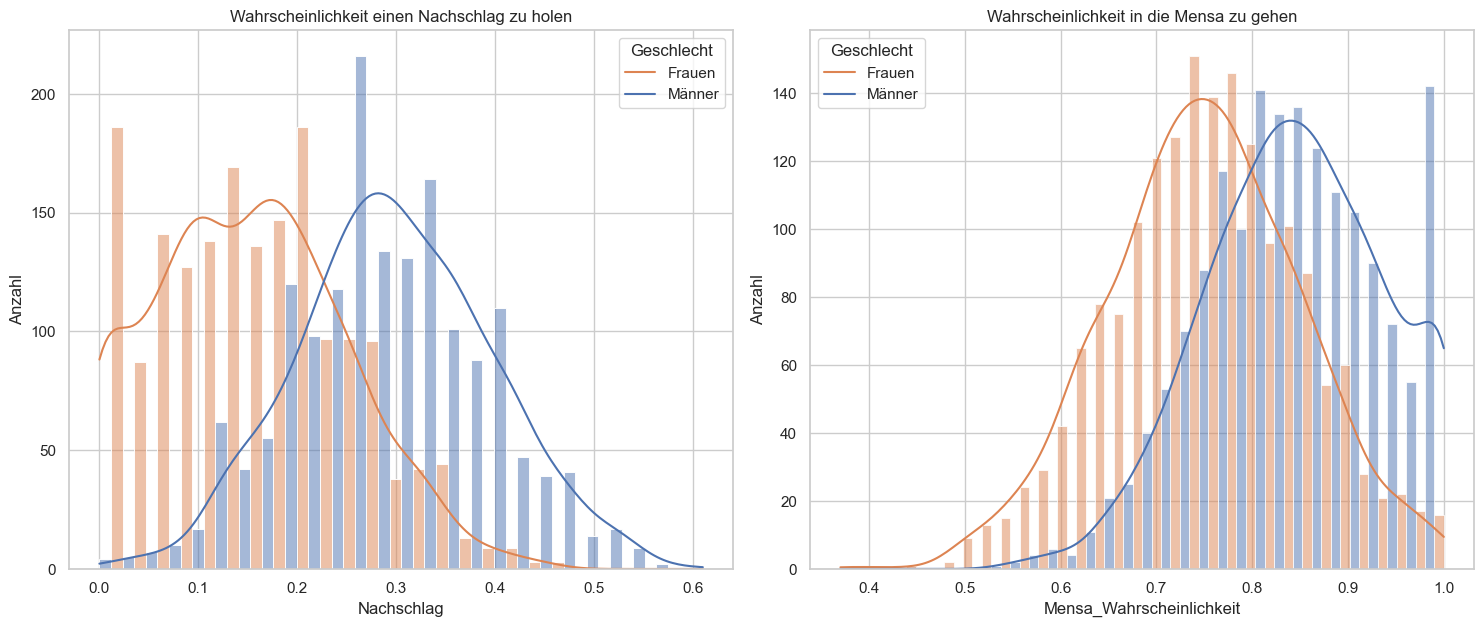

In [58]:
# Set the style for better visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# Create a subplot layout
plt.subplot(2, 2, 1)
# Visualize the distribution of Nachschlag by gender
sns.histplot(data=studenten_df, x="Nachschlag", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Wahrscheinlichkeit einen Nachschlag zu holen")
plt.xlabel("Nachschlag")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

plt.subplot(2, 2, 2)
# Visualize the distribution of Mensa_Wahrscheinlichkeit by gender
sns.histplot(data=studenten_df, x="Mensa_Wahrscheinlichkeit", hue="Geschlecht", kde=True, multiple="dodge")
plt.title("Wahrscheinlichkeit in die Mensa zu gehen")
plt.xlabel("Mensa_Wahrscheinlichkeit")
plt.ylabel("Anzahl")
plt.legend(title="Geschlecht", labels=["Frauen", "Männer"])

plt.tight_layout()
plt.show()

# Daten exportieren

In [59]:
studenten_df.to_csv('studenten_df.csv', index=False)
studenten_df.head()

,M_nr,Kurs,Geschlecht,Vegetarier,Obst,Salat,Nachschlag,Mensa_Wahrscheinlichkeit
0,10000,KA-GAGPW24B1,m,True,0.837421,0.162579,0.36,0.94
1,10001,KA-GAGPW24B1,w,False,0.469515,0.530485,0.24,0.77
2,10002,KA-GAGPW24B1,m,False,0.147707,0.852293,0.15,0.80
3,10003,KA-GAGPW24B1,m,False,0.149874,0.850126,0.41,0.78
4,10004,KA-GAGPW24B1,m,True,0.231199,0.768801,0.38,0.96


In [60]:
df_vorlesungen_final.head(1000)

,V_ID,summary,Datum,Beginn,Ende,Kurs,Vormittag
0,1,Vorlesung 1,2025-06-16,08:00:00,10:00:00,Mathe,True
1,2,Vorlesung 2,2025-06-16,13:30:00,15:00:00,Informatik,False
